# EquiBoots Bias and Fairness Assessments

## Overview

This notebook demonstrates how to use the EquiBoots package to assess bias and fairness in classification models. Specifically, it walks through a mock-up example using synthetic classification data to:

- Simulate predictions and true labels
- Slice the data by sensitive attributes (e.g., race, gender)
- Evaluate group-based fairness metrics (e.g., TPR disparity, accuracy parity)
- Visualize disparities using violin, box, and other supported plots

The goal is to provide a reproducible, hands-on example of how to leverage `EquiBoots` for auditing model performance across demographic subgroups. This is especially useful for practitioners aiming to build more equitable machine learning systems.

**Note:** Prefer to run this in the cloud? You can open this notebook directly in [Google Colab](https://colab.research.google.com/drive/1HfCFWrBStJds-B5uomwNW6C7_adVRaIE#scrollTo=MY3SJAUFbTgQ).

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/lshpaner/Documents/GitHub_Repositories/equi_boots/py_scripts


In [2]:
import equiboots as eqb

## Prepping equiboots

### Classification Mock-Up

The code below generates synthetic classification data and prepares it for group-based fairness analysis using `equiboots`. It includes:

- Simulated predictions and ground truth labels
- Demographic group features (race and sex)
- Construction of a `fairness_df` with group attributes
- Initialization of the `EquiBoots` object for slicing and grouping data

In [3]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

Groups created


### Overlay ROC AUC

The cells below generates an overlayed ROC curve visualization for different race groups using the `eq_plot_group_curves` function. It helps assess model performance disparities across demographic subgroups by comparing their respective ROC curves.

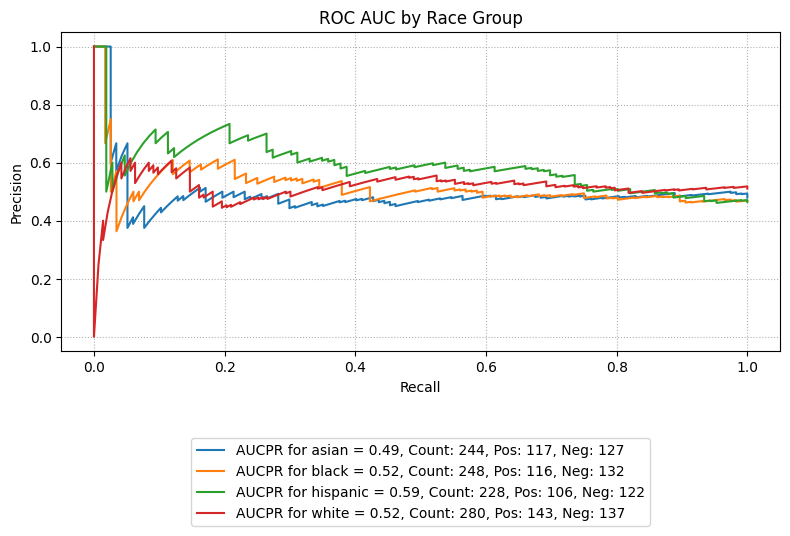

In [4]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    # filename="bla",
    title="ROC AUC by Race Group",
    n_bins=10,
    # group="black",
    # exclude_groups=["black", "asian"],
    save_path="./images",
)

### Subplots

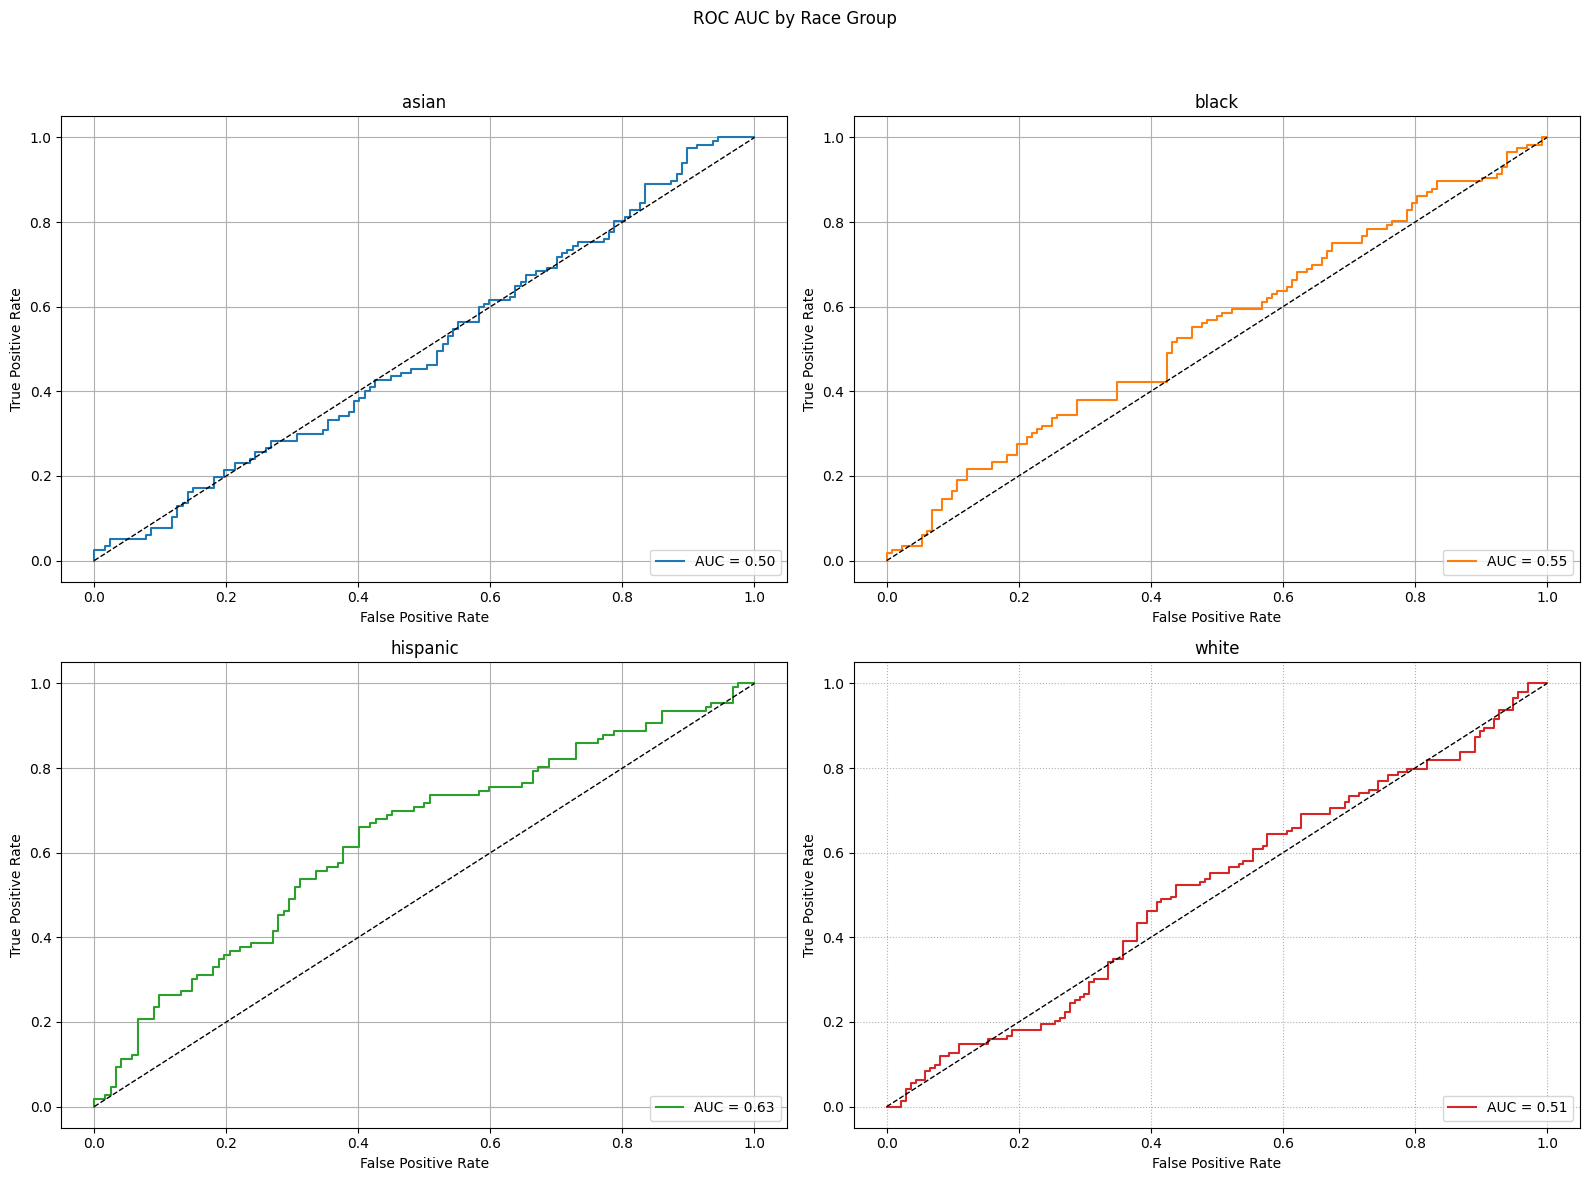

In [5]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="roc",
    title="ROC AUC by Race Group",
    # figsize=(5, 5),
    decimal_places=2,
    subplots=True,
)

### Example of Single Race Group

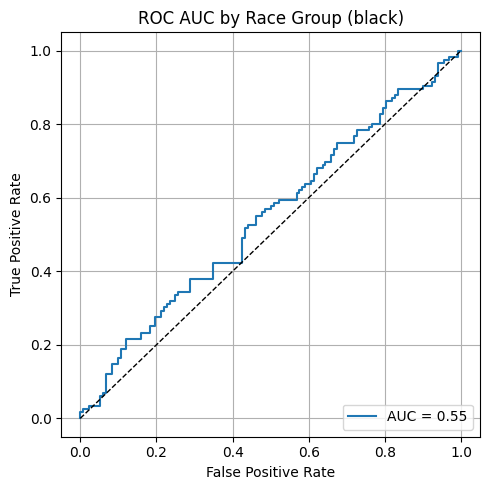

In [6]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="roc",
    title="ROC AUC by Race Group",
    figsize=(5, 5),
    group="black",
    color_by_group=False,
)

## Precision-Recall Curves

### Overlay Precision-Recall Curves

The cells below generates an overlayed ROC curve visualization for different race groups using the `eq_plot_group_curves` function. It helps assess model performance disparities across demographic subgroups by comparing their respective ROC curves.

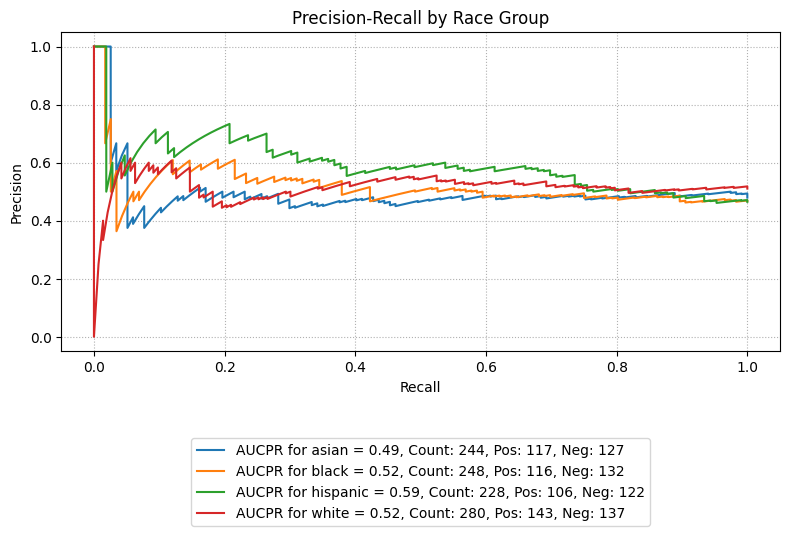

In [7]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    title="Precision-Recall by Race Group",
)

### Subplots

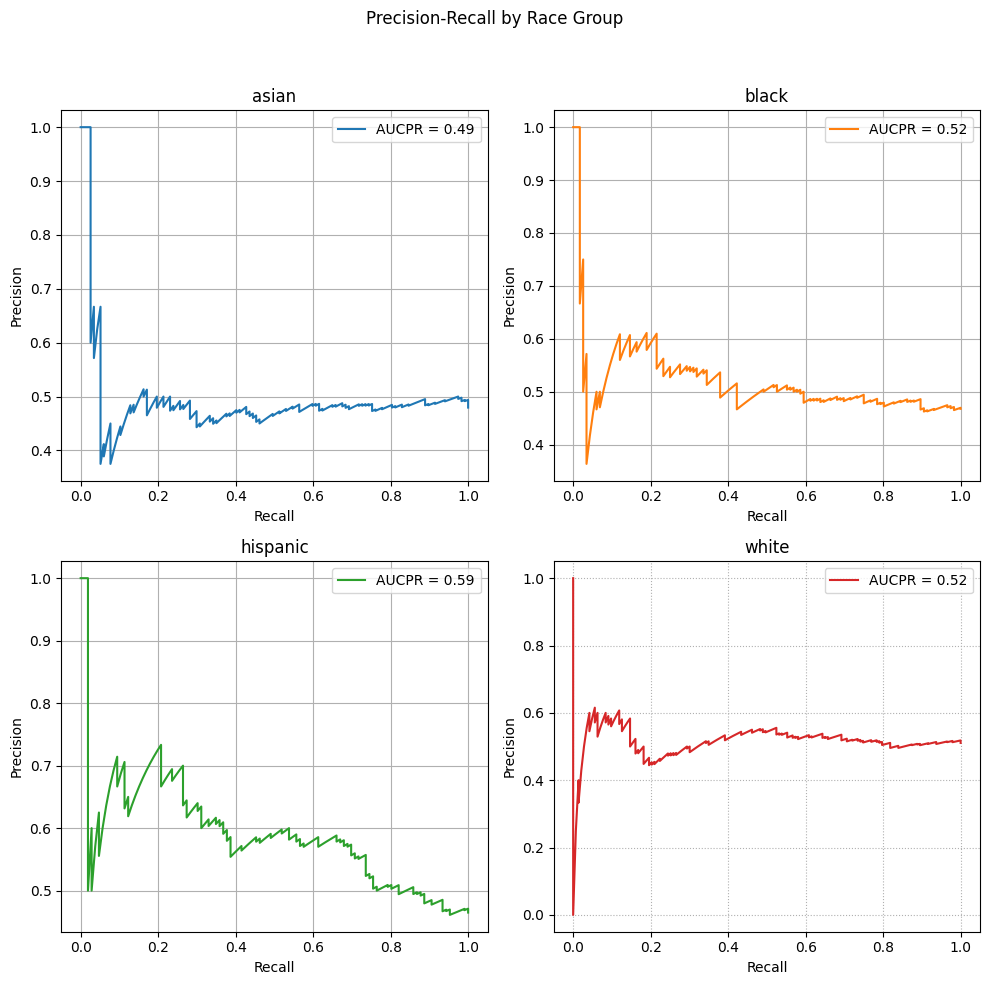

In [8]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    title="Precision-Recall by Race Group",
    filename="race",
    figsize=(5, 5),
    decimal_places=2,
    n_cols=2,
    # show_grid=False,
    subplots=True,
)

### Example of Single Race Group

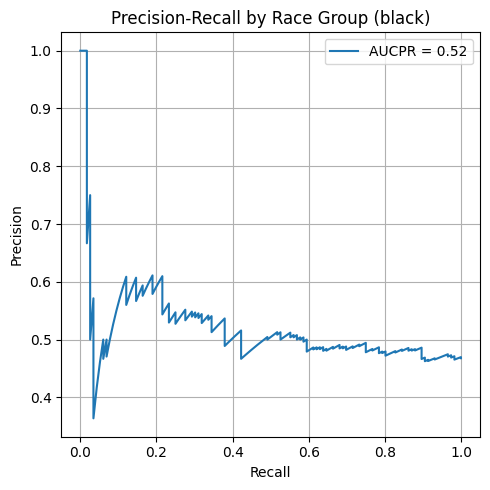

In [9]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    title="Precision-Recall by Race Group",
    figsize=(5, 5),
    group="black",
    color_by_group=False,
)

## Calibration Plot

### Overlay


The following cell generates calibration curves for each race group to visualize how well predicted probabilities align with actual outcomes. Using the `eq_plot_group_curves` function in overlay mode. This is a useful diagnostic for evaluating model reliability and potential miscalibration across demographic subgroups.

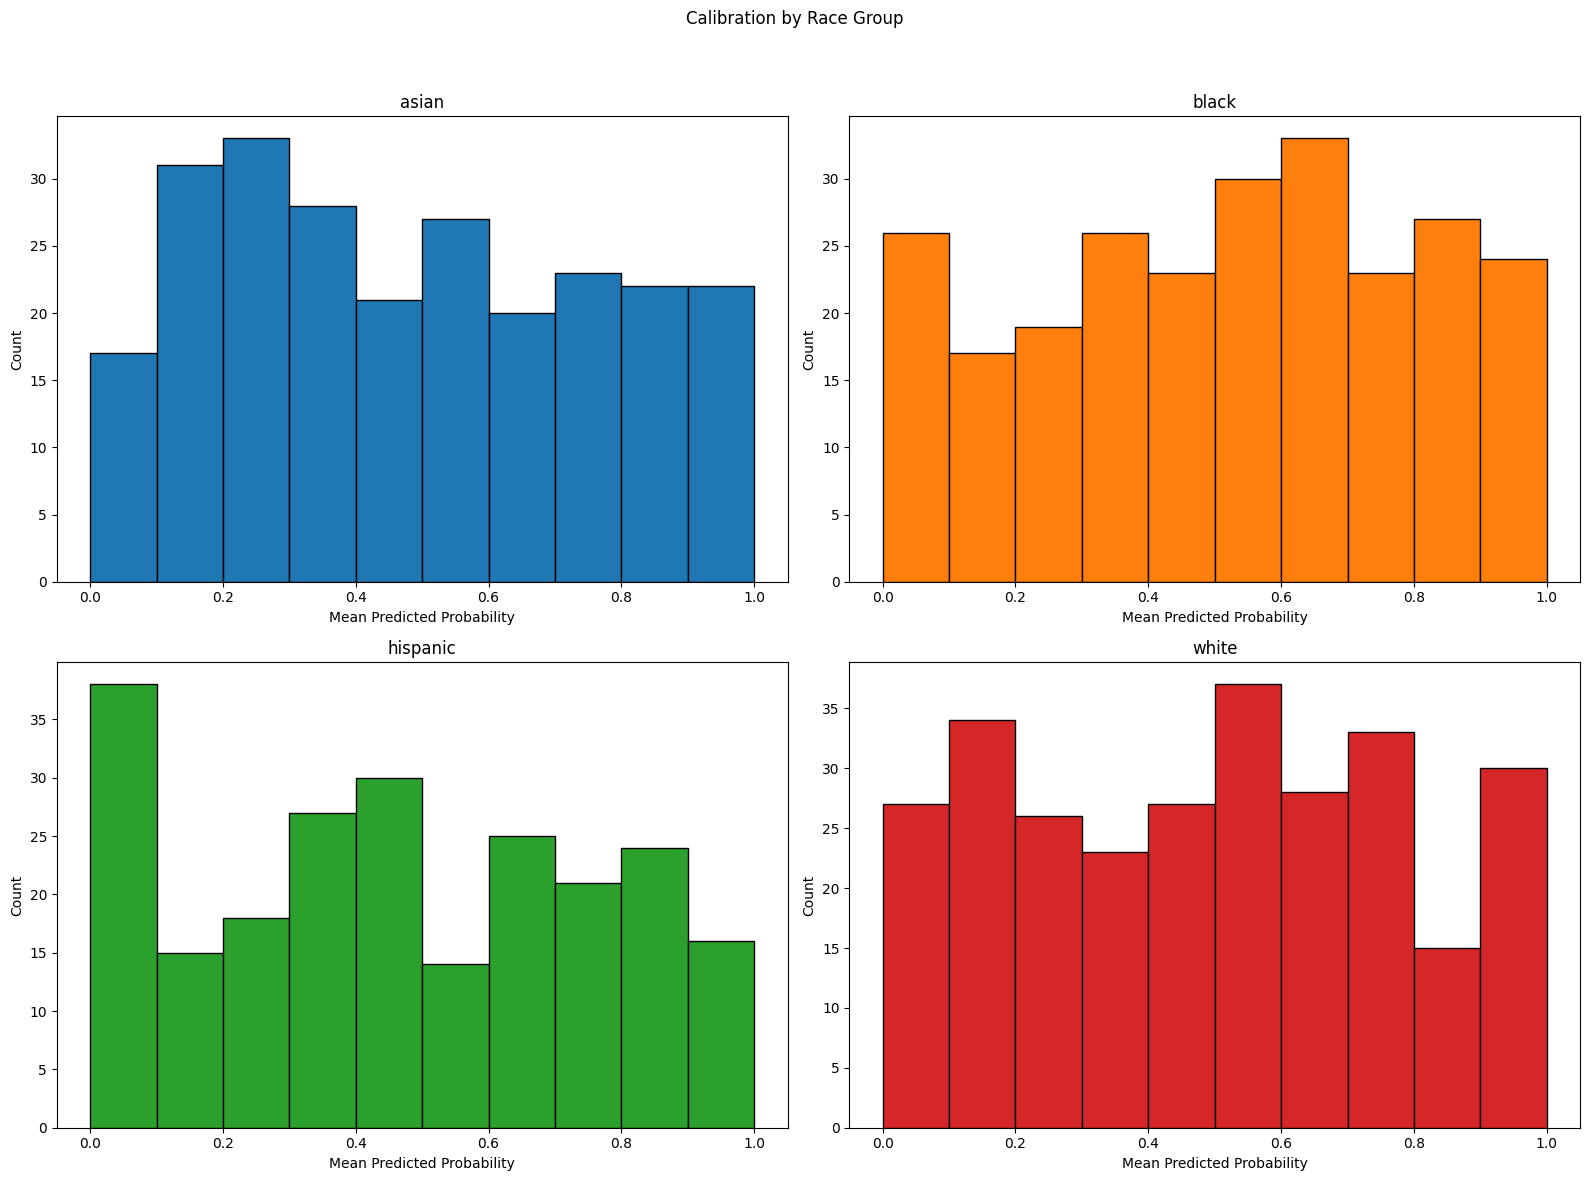

In [37]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    n_bins=10,
    show_grid=False,
    plot_hist=True,
    # subplots=True,
    # exclude_groups="white",
)

### Subplots

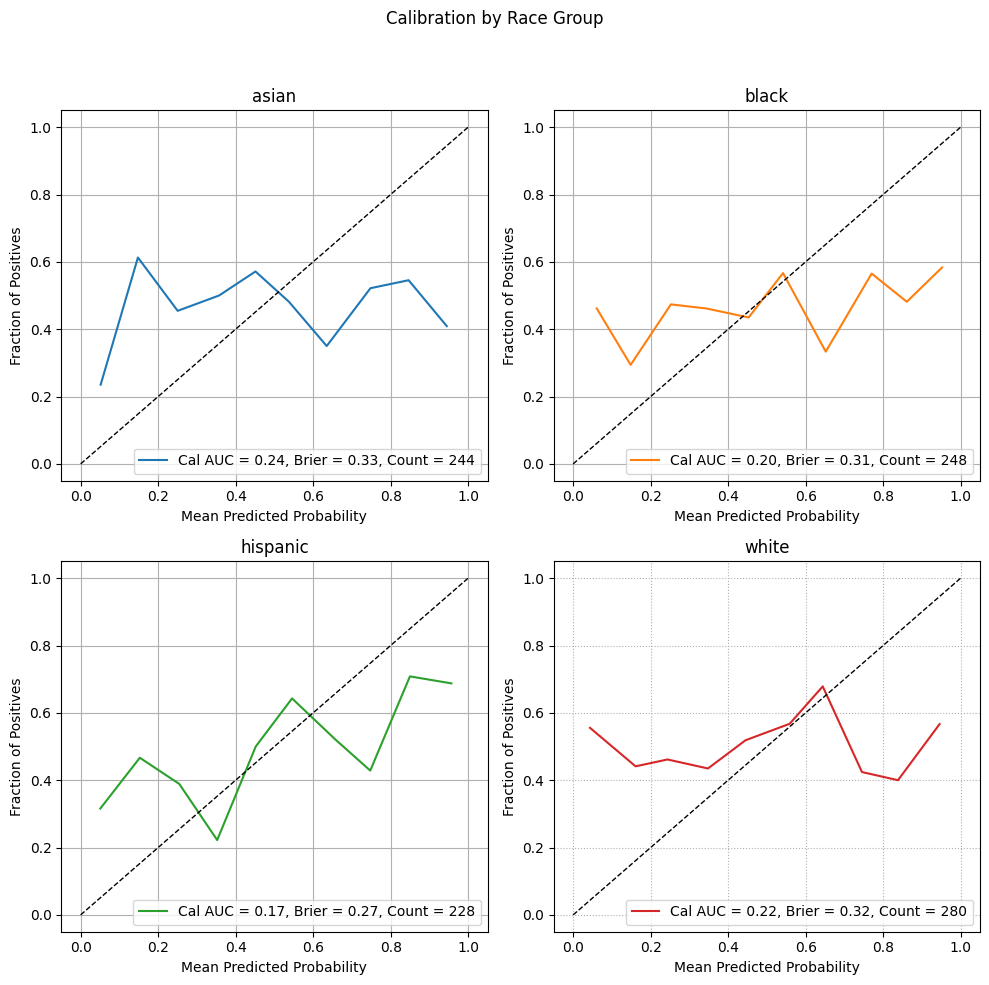

In [11]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    figsize=(5, 5),
    decimal_places=2,
    subplots=True,
)

### Example of Single Race Group

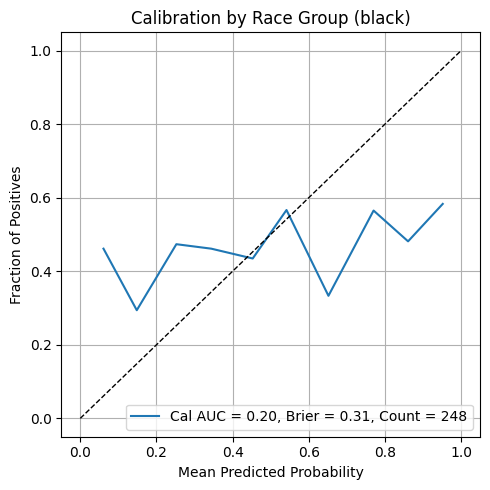

In [12]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    figsize=(5, 5),
    group="black",
    color_by_group=False,
)

## Locally Weighted Scatterplot Smoothing (LOWESS) Calibration Curve

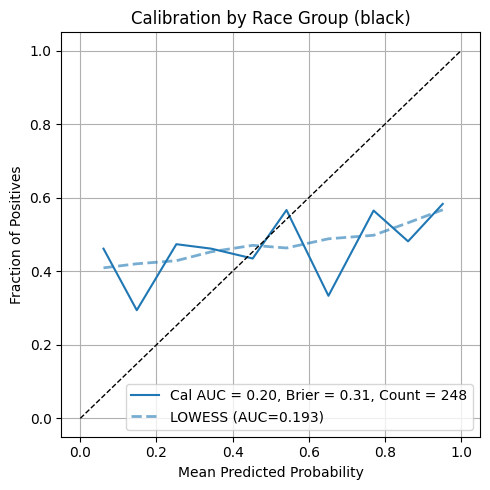

In [13]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    figsize=(5, 5),
    group="black",
    lowess=0.6,
    lowess_kwargs={"linestyle": "--", "linewidth": 2, "alpha": 0.6},
    color_by_group=False,
)

## Disparities and Point Estimate Graphs

This section sets up the `EquiBoots` class to compute fairness disparities across race and sex groups using both bootstrapped and non-bootstrapped strategies. Key elements include:

- Initialization of the `EquiBoots` object with bootstrapping enabled (`bootstrap_flag=True`)
- Seeding for reproducibility across 10 boot iterations
- Grouping and slicing by demographic variables
- Metric computation and disparity calculation per group (e.g., race)
- Final output prepared in a long-form DataFrame for visualization

### Disparity (Bootstrapped)

In [14]:
eq2 = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()
eq2.set_fix_seeds(int_list)
print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])

boots_race_data = eq2.slicer("race")
race_metrics = eq2.get_metrics(boots_race_data)
dispa = eq2.calculate_disparities(race_metrics, "race")


boots_sex_data = eq2.slicer("sex")
sex_metrics = eq2.get_metrics(boots_sex_data)

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 543.85it/s]


Groups created
Calculating metrics for each bootstrap:


100%|██████████| 10/10 [00:00<00:00, 84.44it/s]


Calculating metrics for each bootstrap:


100%|██████████| 10/10 [00:00<00:00, 169.76it/s]


### Bootstrapped Disparities (and General Metrics (Non-Disparity)) (Pass/Fail)

The following violinplots show the disparity metrics within threshold for what they are. In the subsequent cell, we will show them for each group as pass or fail. Below we define new variables using the EquiBoots class to calculate disparities
for race and sex groups such that they can be used in the point estimates plot.

#### Bootstrapped Disparities (Pass/Fail)

/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-pack

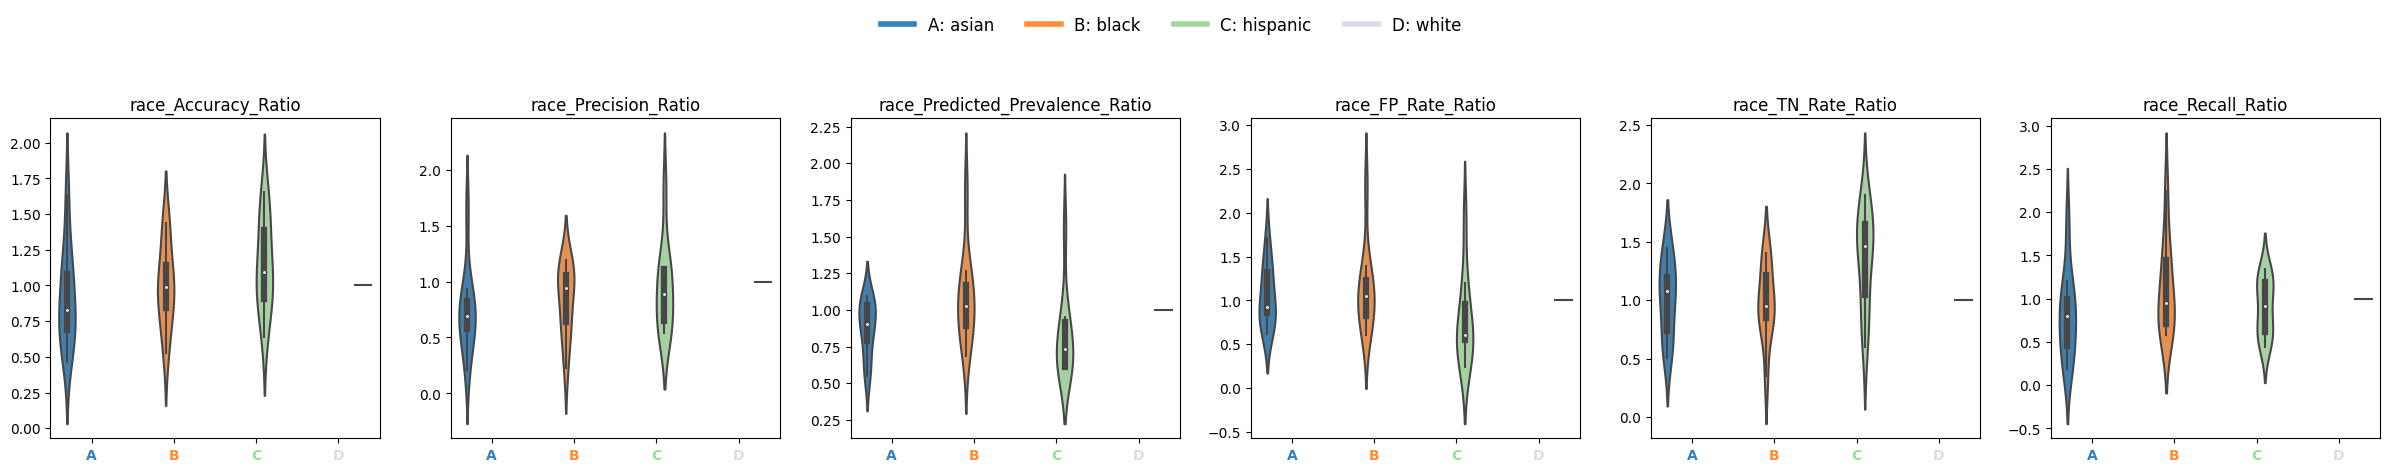

In [15]:
eqb.eq_group_metrics_plot(
    group_metrics=dispa,
    metric_cols=[
        "Accuracy_Ratio",
        "Precision_Ratio",
        "Predicted_Prevalence_Ratio",
        "FP_Rate_Ratio",
        "TN_Rate_Ratio",
        "Recall_Ratio",
    ],
    name="race",
    categories="all",
    # figsize=(24, 4),
    plot_type="violinplot",
    color_by_group=True,
    show_grid=False,
    strict_layout=True,
    save_path="./images",
    # max_cols=3,
    # show_pass_fail=True,
    # y_lim=(-2, 4),
    leg_cols=7,
    plot_thresholds=[0.9, 1.2],
)

In [16]:
race_metrics

[{'asian': {'Accuracy': 0.5,
   'Precision': np.float64(0.375),
   'Recall': np.float64(0.3),
   'F1 Score': np.float64(0.3333333333333333),
   'Specificity': np.float64(0.6428571428571429),
   'TP Rate': np.float64(0.3),
   'FP Rate': np.float64(0.35714285714285715),
   'FN Rate': np.float64(0.7),
   'TN Rate': np.float64(0.6428571428571429),
   'TP': np.int64(3),
   'FP': np.int64(5),
   'FN': np.int64(7),
   'TN': np.int64(9),
   'Prevalence': np.float64(0.4166666666666667),
   'Predicted Prevalence': np.float64(0.3333333333333333),
   'ROC AUC': np.float64(0.45),
   'Average Precision Score': np.float64(0.4693133337250984),
   'Log Loss': 0.9347791878812991,
   'Brier Score': np.float64(0.3346975812022608),
   'Calibration AUC': np.float64(0.322259272570008)},
  'white': {'Accuracy': 0.4642857142857143,
   'Precision': np.float64(0.6666666666666666),
   'Recall': np.float64(0.3333333333333333),
   'F1 Score': np.float64(0.4444444444444444),
   'Specificity': np.float64(0.7),
   'TP

/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-pack

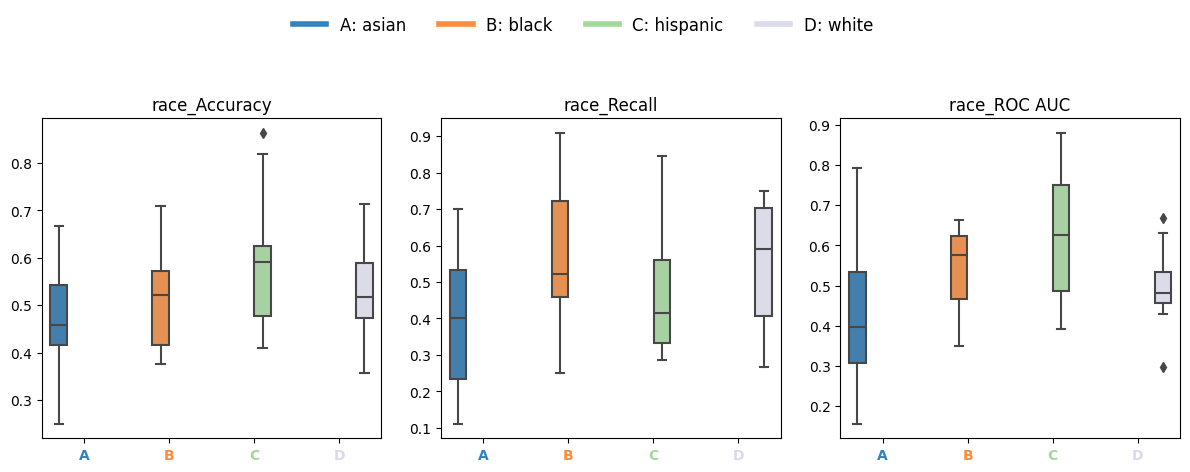

In [17]:
eqb.eq_group_metrics_plot(
    group_metrics=race_metrics,
    metric_cols=["Accuracy", "Recall", "ROC AUC"],
    name="race",
    categories="all",
    figsize=(12, 4),
    plot_type="boxplot",
    color_by_group=True,
    show_grid=False,
    strict_layout=True,
    save_path="./images",
    show_pass_fail=False,
    # y_lim=(-2, 4),
    # disparity_thresholds=[0.9, 1.2],
)

Below we define new variables using the EquiBoots class to calculate disparities and non-disparity metrics for race and sex groups such that they can be used in the point estimates plot.

In [18]:
eq3 = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=False,
)

eq3.grouper(groupings_vars=["race", "sex"])
sliced_data = eq3.slicer("race")

data_race = eq3.slicer("race")
data_sex = eq3.slicer("sex")

race_metrics_3 = eq3.get_metrics(data_race)
sex_metrics_3 = eq3.get_metrics(data_sex)

dispa_race = eq3.calculate_disparities(race_metrics_3, "race")
dispa_sex = eq3.calculate_disparities(sex_metrics_3, "sex")

Groups created


### Point Estimate Disparities and General (Non-Disparity) Metrics (Pass/Fail)

The following violinplots show the disparity metrics within threshold for what they are. In the ensuing cell, we will show them for each group as pass or fail.

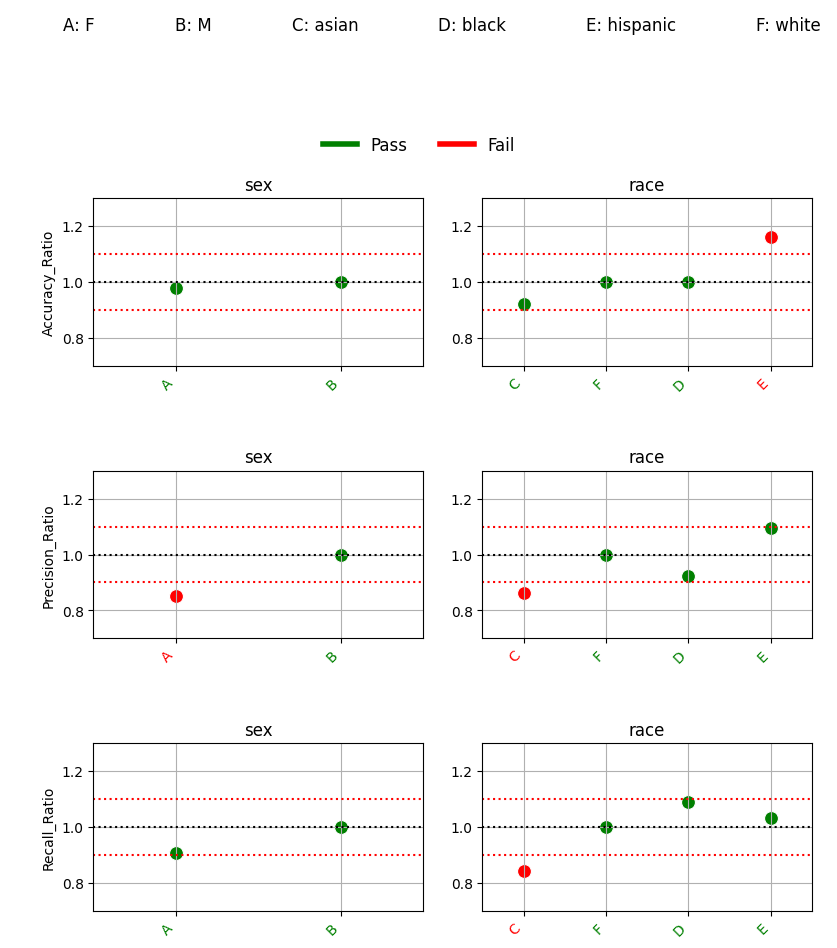

In [19]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[dispa_sex, dispa_race],
    metric_cols=[
        "Accuracy_Ratio",
        "Precision_Ratio",
        "Recall_Ratio",
    ],
    category_names=["sex", "race"],
    figsize=(8, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    show_pass_fail=True,
    # raw_metrics=False,
    show_grid=True,
    y_lim=(0.7, 1.3),
    leg_cols=6,
    # y_lim=(0, 0.9),
)

### Point Estimates

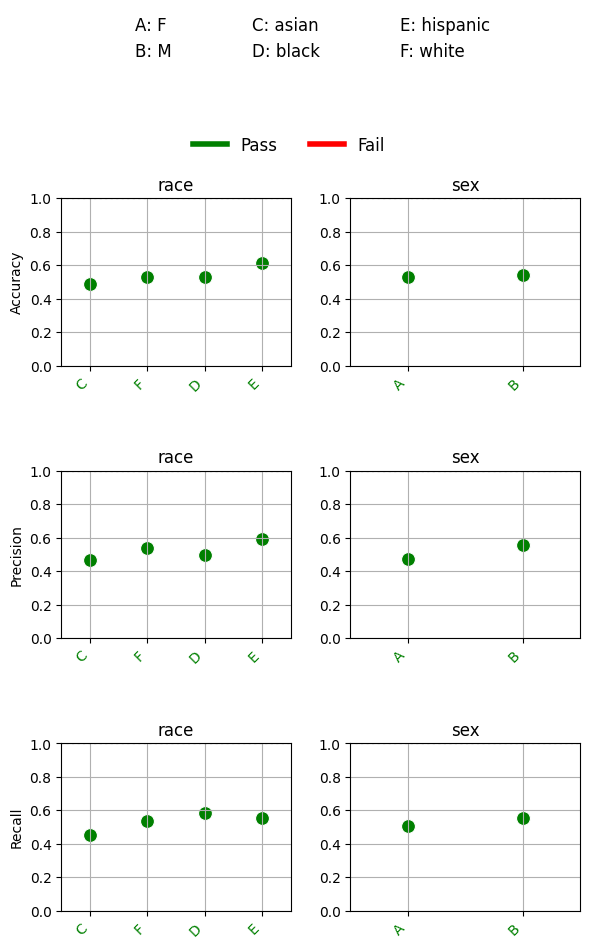

In [20]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[race_metrics_3, sex_metrics_3],
    metric_cols=[
        "Accuracy",
        "Precision",
        "Recall",
    ],
    category_names=["race", "sex"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    show_pass_fail=True,
    raw_metrics=True,
    show_grid=True,
    y_lim=(0, 1),
)

In [21]:
test_config = {
    "test_type": "chi_square",
    "alpha": 0.05,
    "adjust_method": "bonferroni",
    "confidence_level": 0.95,
    "classification_task": "binary_classification",
}
stat_test_results = eq.analyze_statistical_significance(
    race_metrics_3, "race", test_config
)

In [22]:
stat_test_results

{'omnibus': StatTestResult(statistic=np.float64(16.307443152969824), p_value=np.float64(0.06073239732851051), is_significant=False, test_name='Chi-Square Test', critical_value=None, effect_size=None, confidence_interval=None)}

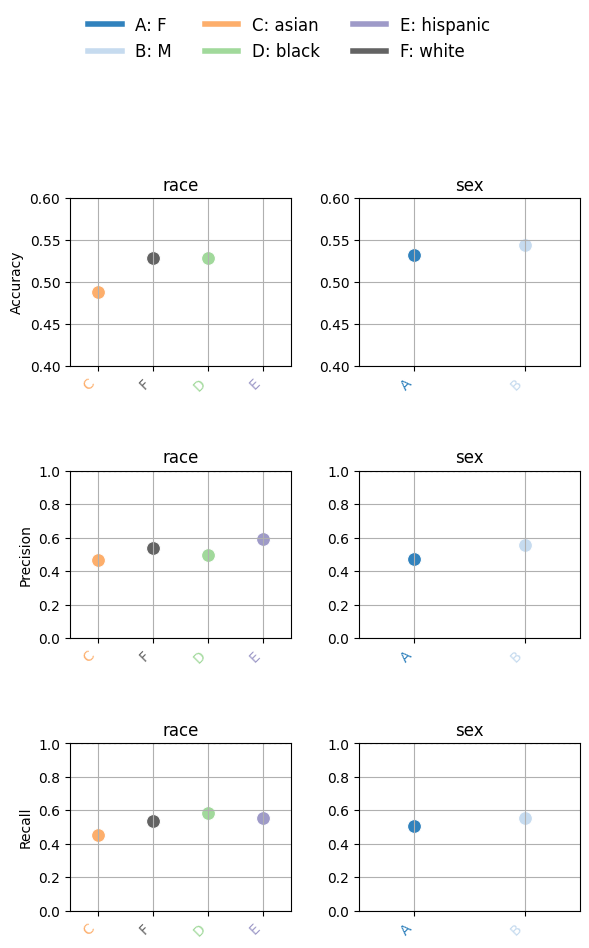

In [23]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[race_metrics_3, sex_metrics_3],
    metric_cols=[
        "Accuracy",
        "Precision",
        "Recall",
    ],
    category_names=["race", "sex"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    raw_metrics=True,
    show_grid=True,
    y_lim=(0, 1),
    show_reference=True,
    y_lims={(0, 0): (0.40, 0.6), (0, 1): (0.40, 0.6)},
)

## Group Metrics Table

The table below aggregates group-level disparity metrics derived from the synthetic classification data. Each row corresponds to a different group or subgroup comparison, and each column represents the ratio of a common performance metric (e.g., accuracy, recall, specificity) between groups.

These ratios help quantify disparities; values close to 1.0 indicate parity, while deviations suggest potential fairness concerns. This summary provides a foundation for further visual or statistical analysis.

> Note: While this example uses disparity metrics (e.g., `Accuracy_Ratio`, `Recall_Ratio`) generated via `calculate_disparities()`, the same structure works with standard group-level metrics as well. If you're using `get_metrics()` instead, simply pass the non-ratio metric columns (e.g., "`Accuracy`", "`Recall`") via the metrics_cols argument to generate a comparable summary table.


In [24]:
disa_metrics_df = eqb.metrics_dataframe(metrics_data=dispa)
disa_metrics_df

,Accuracy_Ratio,Precision_Ratio,Recall_Ratio,F1_Score_Ratio,Specificity_Ratio,TP_Rate_Ratio,FP_Rate_Ratio,FN_Rate_Ratio,TN_Rate_Ratio,Prevalence_Ratio,Predicted_Prevalence_Ratio,ROC_AUC_Ratio,Average_Precision_Score_Ratio,Log_Loss_Ratio,Brier_Score_Ratio,Calibration_AUC_Ratio,attribute_value
0,1.076923,0.562500,0.900000,0.750000,0.918367,0.900000,1.190476,1.050000,0.918367,0.648148,1.037037,0.964286,0.748393,0.937216,0.965496,1.063712,asian
1,0.758333,0.622222,0.933333,0.746667,0.642857,0.933333,1.714286,1.200000,0.642857,0.729167,1.093750,0.850059,0.754133,1.078738,1.169075,1.051768,asian
2,1.244444,0.848485,1.209091,1.012397,1.446429,1.209091,0.642857,0.712500,1.446429,0.614035,0.875000,1.489874,0.959236,0.566781,0.566701,0.650487,asian
3,1.083333,0.937500,1.022727,0.978261,1.166667,1.022727,0.857143,0.974026,1.166667,0.855556,0.933333,1.068416,0.876467,0.898052,0.883378,1.057409,asian
4,0.666667,0.209877,0.185185,0.197531,1.213333,0.185185,0.866667,2.222222,1.213333,0.700000,0.617647,0.746567,0.500695,0.976228,1.017265,1.111398,asian
5,0.897436,0.666667,0.611111,0.638889,1.007407,0.611111,0.991667,1.222222,1.007407,0.954545,0.875000,0.571389,0.843871,0.841727,1.016020,1.280534,asian
6,0.686275,0.714286,0.687500,0.703125,0.674603,0.687500,1.366071,1.833333,0.674603,1.060606,1.020833,0.448800,0.610915,1.421076,1.655321,1.076851,asian
7,1.633333,1.650000,1.875000,1.772727,1.444444,1.875000,0.619048,0.681818,1.444444,0.933333,1.060606,2.101293,1.517394,0.562959,0.598655,0.328870,asian
8,0.686275,0.425000,0.280000,0.344444,1.142857,0.280000,0.857143,2.800000,1.142857,0.833333,0.549020,0.613333,0.645216,1.373620,1.360251,1.310686,asian
9,0.466667,0.772727,0.400000,0.557692,0.507937,0.400000,1.382716,2.200000,0.507937,1.458333,0.754902,0.339394,1.015388,1.199278,1.279476,1.755646,asian


## Bootstrapped ROC AUC, Precision-Recall, and Calibration Curves

### ROCAUC Bootstrap

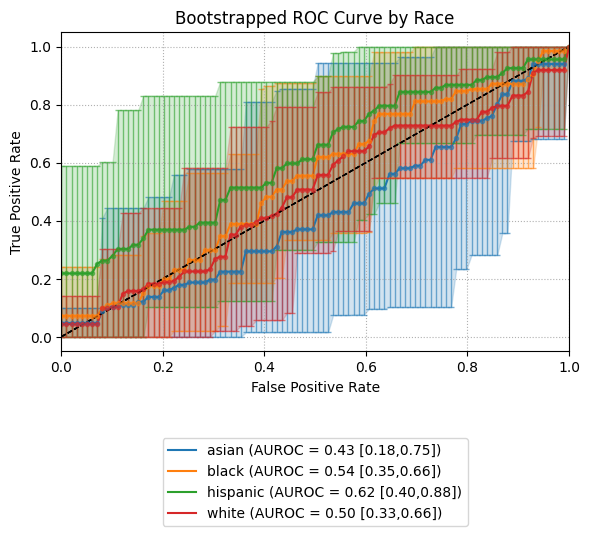

In [25]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=boots_race_data,
    curve_type="roc",
    title="Bootstrapped ROC Curve by Race",
    filename="boot_roc_race",
    save_path="./images",
    # subplots=True,
    bar_every=100,
    dpi=100,
    n_bins=10,
    figsize=(6, 6),
    color_by_group=True,
)

### Precision-Recall Bootstrap

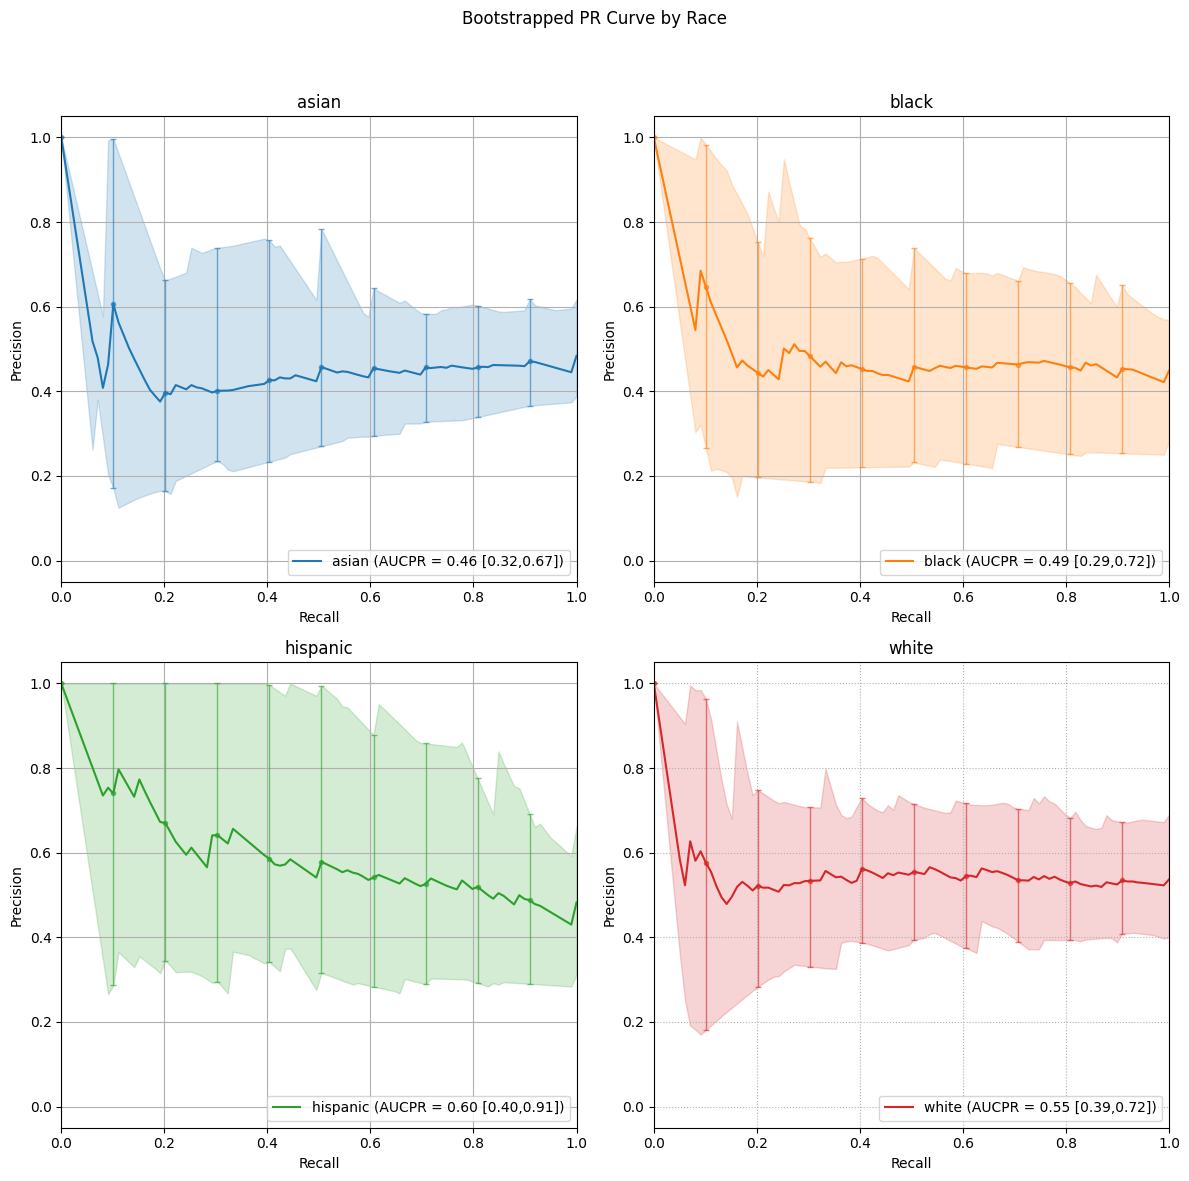

In [26]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=boots_race_data,
    curve_type="pr",
    title="Bootstrapped PR Curve by Race",
    figsize=(6, 6),
    color_by_group=True,
    subplots=True,
    # exclude_groups=247,
)

### Calibration Plots Bootstrapped

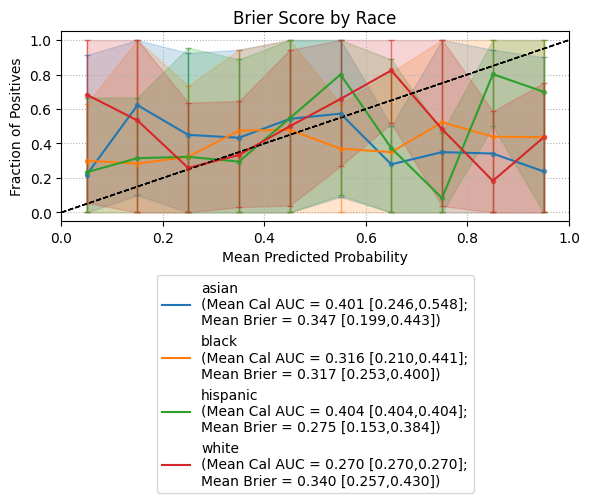

In [27]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=boots_race_data,
    curve_type="calibration",
    title="Brier Score by Race",
    figsize=(6, 6),
    color_by_group=True,
)

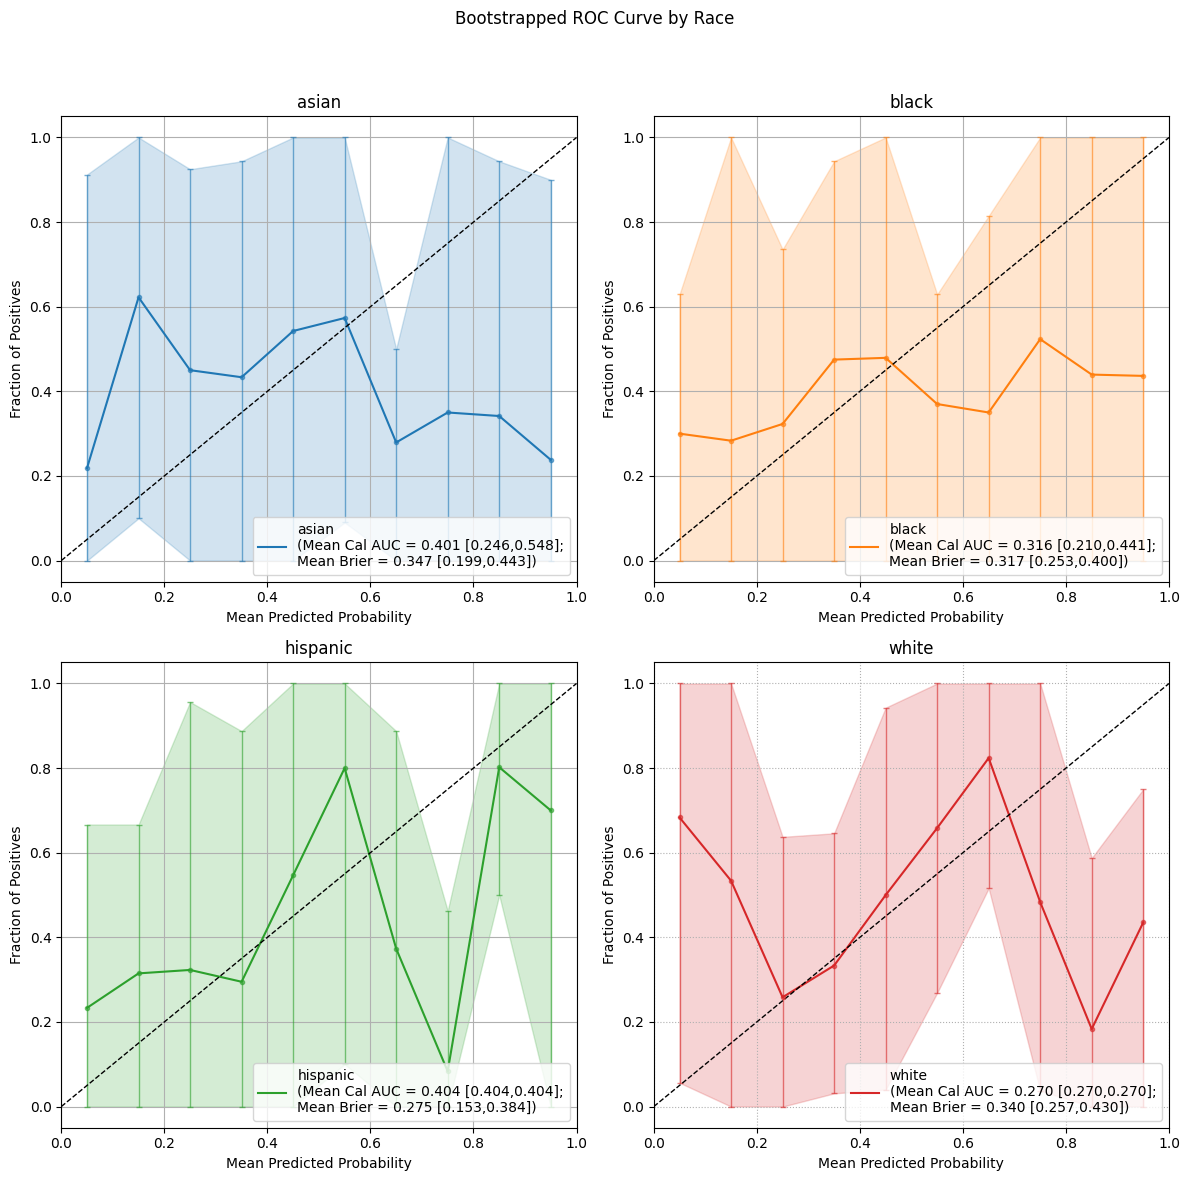

In [28]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=boots_race_data,
    curve_type="calibration",
    title="Bootstrapped ROC Curve by Race",
    figsize=(6, 6),
    subplots=True,
    color_by_group=True,
)

## Regression Mock-Up

In [29]:
## Generate synthetic regression-like data
np.random.seed(42)
y_true = np.random.normal(loc=50, scale=10, size=1000)  ## continuous target
y_pred = y_true + np.random.normal(
    loc=0, scale=5, size=1000
)  # predicted value with noise

# Not really 'prob', but using this slot for predicted values
y_prob = y_pred

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq3 = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    task="regression",
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq3.grouper(groupings_vars=["race", "sex"])
sliced_data_2 = eq3.slicer("race")

Groups created


### Regression Residuals

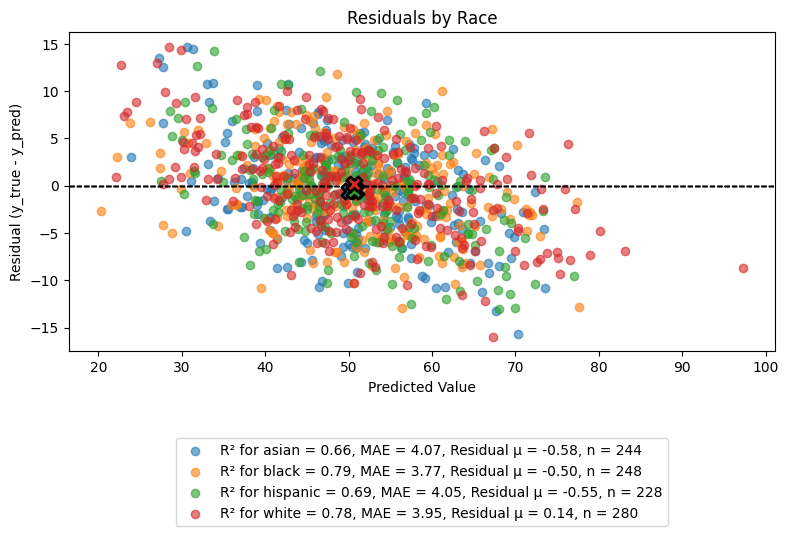

In [30]:
eqb.eq_plot_residuals_by_group(
    data=sliced_data_2,
    # y_true=y_true,
    # y_prob=y_pred,
    # group="black",
    title="Residuals by Race",
    filename="residuals_by_race",
    # subplots=True,
    # group="black",
    color_by_group=True,
    # n_cols=1,
    # n_rows=2,
    figsize=(8, 6),
    # group="black",
    show_centroids=True,
    save_path="./images",
    # exclude_groups="white",
    show_grid=False,
)

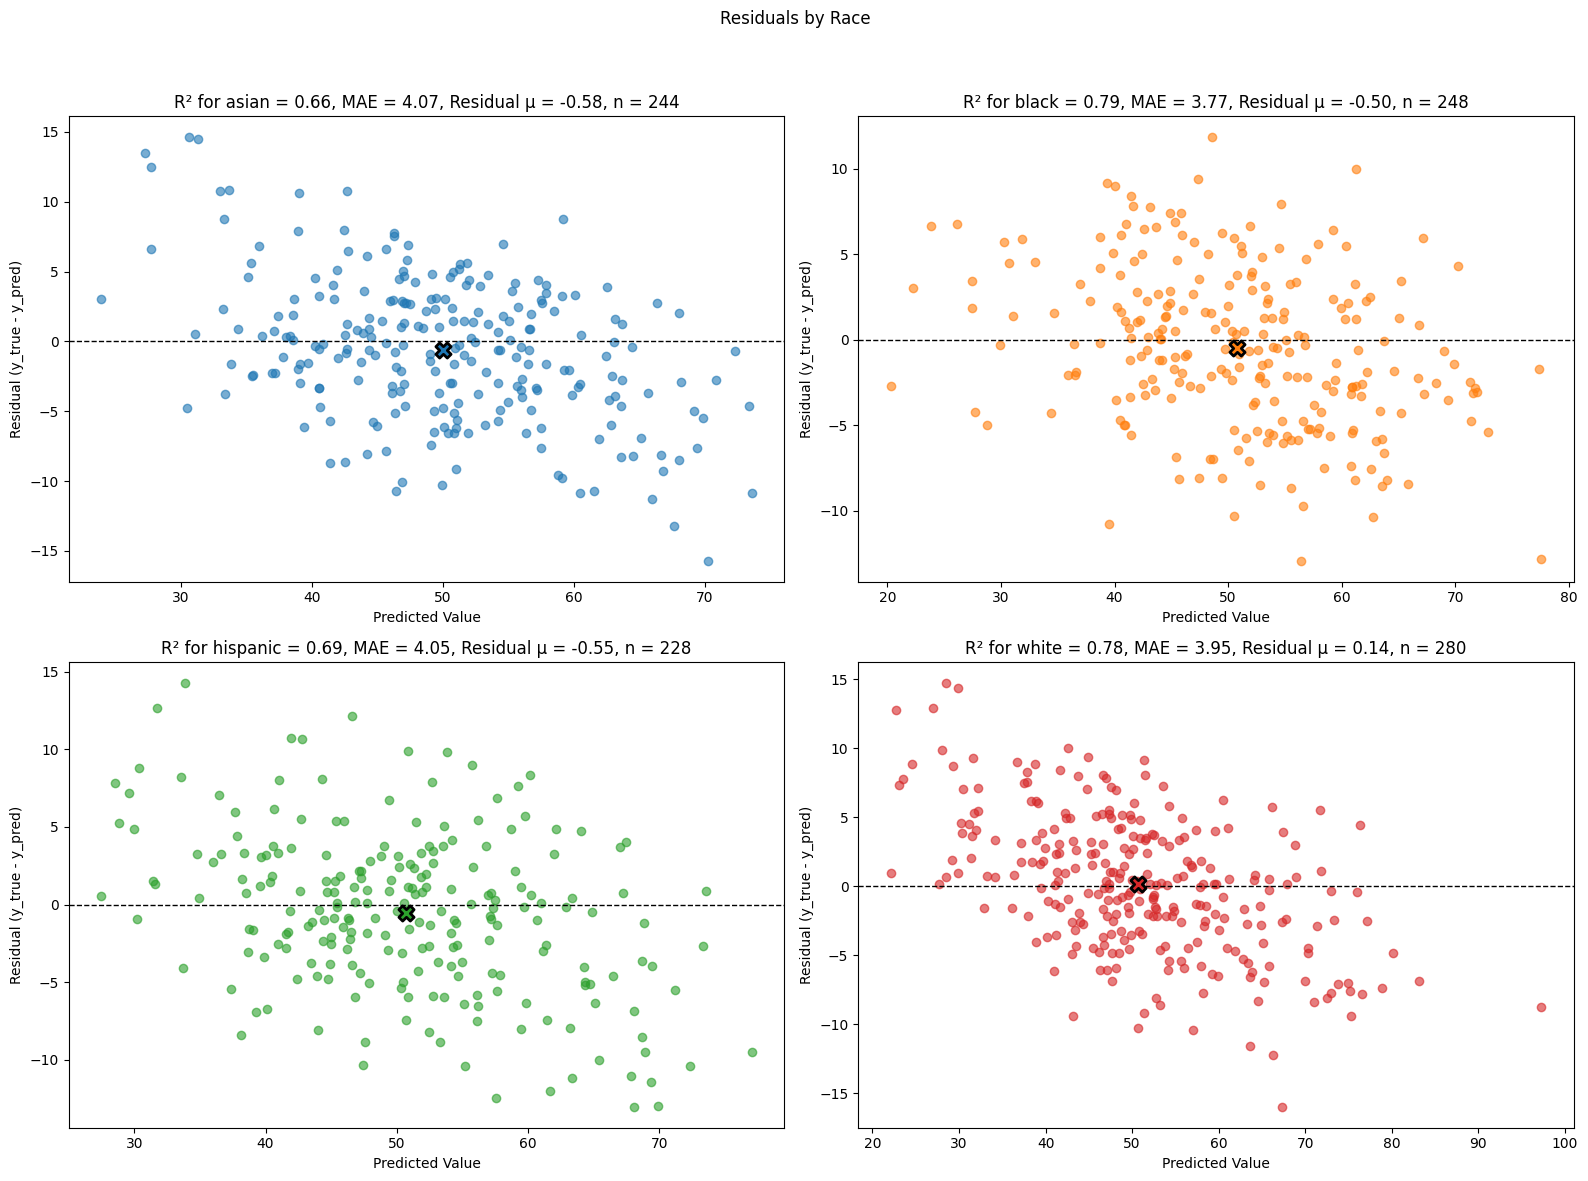

In [31]:
eqb.eq_plot_residuals_by_group(
    data=sliced_data_2,
    title="Residuals by Race",
    filename="residuals_by_race",
    subplots=True,
    # group="black",
    color_by_group=True,
    figsize=(8, 6),
    # group="black",
    show_centroids=True,
    save_path="./images",
    # exclude_groups="white",
    show_grid=False,
)